# Part I) Input prompt feature extraction

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import spacy 
import textstat
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns


## I) Preprocessing

### a) Data Loading task 1

In [2]:
generation_file_task1 = 'dataset/hallulens_data/task1_merged_generation.jsonl'
eval_result_task1 = 'dataset/hallulens_data/task1_merged_hallucination_scores.jsonl'


generation_task1_df = pd.read_json(generation_file_task1, lines=True)
evaluation_task1_df = pd.read_json(eval_result_task1, lines=True)

In [3]:
generation_task1_df

,title,h_score_cat,pageid,revid,description,categories,reference,prompt,answer,generation,run_id
0,Jan Willem Spruyt,0,16859978,1154166135,"Schoolteacher, South African civil servant, la...","[1826 births, 1908 deaths, 19th-century Dutch ...",Jan Willem Spruyt (4 July 1826 – 8 September 1...,What position did Jan Willem Spruyt hold in th...,Government secretary.,Jan Willem Spruyt served as the State Attorney...,task_1_run_1
1,HMS Prize,0,58453794,1102135374,German schooner captured and refitted as a Bri...,"[Q-ships of the Royal Navy, World War I naval ...",## Service as a Q ship First Prize underwent a...,What was the new name given to First Prize by ...,HMS Prize,"The vessel originally known as ""First Prize"" w...",task_1_run_1
2,Mississippi Highway 902,0,58127285,1061978358,Highway in Mississippi,"[State highways in Mississippi, Transportation...","Mississippi Highway 902 (MS 902, also known as...",What is the northern terminus of Mississippi H...,MS 35 in Lorena.,Mississippi Highway 902 (MS 902) does not have...,task_1_run_1
3,St. Elmo (1910 Thanhouser film),1,45082337,1168621248,None,"[1910 drama films, 1910 films, 1910s American ...",## Plot\n\nThe plot was adapted from Augusta J...,Who is betrothed to St. Elmo in the film?,Agnes,"In the 1985 film ""St. Elmo's Fire,"" there is n...",task_1_run_1
4,Oddfellows (album),1,37222693,1154749417,None,"[2013 albums, Ipecac Recordings albums, Tomaha...",## Release\n\nOddfellows was released on Janua...,What date was the album Oddfellows released?,"January 29, 2013","The album ""Oddfellows"" by Tomahawk was release...",task_1_run_1
...,...,...,...,...,...,...,...,...,...,...,...
1761,Sara Ramirez,7,1999305,1173275338,American actor and singer,"[1975 births, 20th-century American LGBT peopl...","## Personal life\n\nOn June 27, 2011, Ramírez ...",What organization did Sara Ramirez donate thei...,Locks of Love,"In September 2016, Sara Ramirez donated their ...",task_1_run_9
1762,Khalili Collection of Japanese Art,7,63416118,1153676727,Private collection of Meiji-era art,"[Japanese art collectors, Khalili Collections]",The Khalili Collection of Japanese Art is a pr...,What is the era of Japanese art featured in th...,Meiji-era (1868–1912),The Khalili Collection of Japanese Art feature...,task_1_run_9
1763,Jimmy Greaves,8,231068,1173499110,English footballer (1940–2021),"[1940 births, 1962 FIFA World Cup players, 196...","Greaves was fit to play in the final, but mana...",Who presented Jimmy Greaves with his World Cup...,Gordon Brown,Jimmy Greaves was presented with his World Cup...,task_1_run_9
1764,4X,8,705620,1168877758,Genre of strategy-based video and board games,"[4X games, Real-time strategy video games, Str...",### Complexity\n\n4X games are known for their...,What aspect of gameplay is prioritized over gr...,Gameplay,"In 4X games, gameplay tends to prioritize stra...",task_1_run_9


In [4]:
evaluation_task1_df

,run_id,halu_test_res
0,task_1_run_1,True
1,task_1_run_1,False
2,task_1_run_1,True
3,task_1_run_1,True
4,task_1_run_1,False
...,...,...
1761,task_1_run_9,False
1762,task_1_run_9,False
1763,task_1_run_9,False
1764,task_1_run_9,False


In [5]:
data_task1 = pd.concat([generation_task1_df, evaluation_task1_df], axis=1)
data_task1

,title,h_score_cat,pageid,revid,description,categories,reference,prompt,answer,generation,run_id,run_id,halu_test_res
0,Jan Willem Spruyt,0,16859978,1154166135,"Schoolteacher, South African civil servant, la...","[1826 births, 1908 deaths, 19th-century Dutch ...",Jan Willem Spruyt (4 July 1826 – 8 September 1...,What position did Jan Willem Spruyt hold in th...,Government secretary.,Jan Willem Spruyt served as the State Attorney...,task_1_run_1,task_1_run_1,True
1,HMS Prize,0,58453794,1102135374,German schooner captured and refitted as a Bri...,"[Q-ships of the Royal Navy, World War I naval ...",## Service as a Q ship First Prize underwent a...,What was the new name given to First Prize by ...,HMS Prize,"The vessel originally known as ""First Prize"" w...",task_1_run_1,task_1_run_1,False
2,Mississippi Highway 902,0,58127285,1061978358,Highway in Mississippi,"[State highways in Mississippi, Transportation...","Mississippi Highway 902 (MS 902, also known as...",What is the northern terminus of Mississippi H...,MS 35 in Lorena.,Mississippi Highway 902 (MS 902) does not have...,task_1_run_1,task_1_run_1,True
3,St. Elmo (1910 Thanhouser film),1,45082337,1168621248,None,"[1910 drama films, 1910 films, 1910s American ...",## Plot\n\nThe plot was adapted from Augusta J...,Who is betrothed to St. Elmo in the film?,Agnes,"In the 1985 film ""St. Elmo's Fire,"" there is n...",task_1_run_1,task_1_run_1,True
4,Oddfellows (album),1,37222693,1154749417,None,"[2013 albums, Ipecac Recordings albums, Tomaha...",## Release\n\nOddfellows was released on Janua...,What date was the album Oddfellows released?,"January 29, 2013","The album ""Oddfellows"" by Tomahawk was release...",task_1_run_1,task_1_run_1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,Sara Ramirez,7,1999305,1173275338,American actor and singer,"[1975 births, 20th-century American LGBT peopl...","## Personal life\n\nOn June 27, 2011, Ramírez ...",What organization did Sara Ramirez donate thei...,Locks of Love,"In September 2016, Sara Ramirez donated their ...",task_1_run_9,task_1_run_9,False
1762,Khalili Collection of Japanese Art,7,63416118,1153676727,Private collection of Meiji-era art,"[Japanese art collectors, Khalili Collections]",The Khalili Collection of Japanese Art is a pr...,What is the era of Japanese art featured in th...,Meiji-era (1868–1912),The Khalili Collection of Japanese Art feature...,task_1_run_9,task_1_run_9,False
1763,Jimmy Greaves,8,231068,1173499110,English footballer (1940–2021),"[1940 births, 1962 FIFA World Cup players, 196...","Greaves was fit to play in the final, but mana...",Who presented Jimmy Greaves with his World Cup...,Gordon Brown,Jimmy Greaves was presented with his World Cup...,task_1_run_9,task_1_run_9,False
1764,4X,8,705620,1168877758,Genre of strategy-based video and board games,"[4X games, Real-time strategy video games, Str...",### Complexity\n\n4X games are known for their...,What aspect of gameplay is prioritized over gr...,Gameplay,"In 4X games, gameplay tends to prioritize stra...",task_1_run_9,task_1_run_9,False


In [6]:
data_task1 = data_task1[['prompt', 'halu_test_res']]
data_task1

,prompt,halu_test_res
0,What position did Jan Willem Spruyt hold in th...,True
1,What was the new name given to First Prize by ...,False
2,What is the northern terminus of Mississippi H...,True
3,Who is betrothed to St. Elmo in the film?,True
4,What date was the album Oddfellows released?,False
...,...,...
1761,What organization did Sara Ramirez donate thei...,False
1762,What is the era of Japanese art featured in th...,False
1763,Who presented Jimmy Greaves with his World Cup...,False
1764,What aspect of gameplay is prioritized over gr...,False


### b) Data Loading task 3

In [7]:
generation_file_task3 = 'dataset/hallulens_data/task3_merged_generation.jsonl'
eval_result_task3 = 'dataset/hallulens_data/task3_merged_hallucination_scores.jsonl'


generation_task3_df = pd.read_json(generation_file_task3, lines=True)
evaluation_task3_df = pd.read_json(eval_result_task3, lines=True)

In [8]:
generation_task3_df

,prompt,name,type,generation,run_id,item_idx
0,I'm curious about the medicine bactocin gargle...,bactocin gargle,medicine,"Bactocin, often referred to in its generic for...",task_3_run_1,0
1,I'd like to learn more about the medicine gota...,gotam divicap,medicine,It seems there may be a typographical or trans...,task_3_run_1,1
2,Could you give me details about the medicine b...,bgmont-lc -kit,medicine,Bgmont-LC Kit is a medication commonly used fo...,task_3_run_1,2
3,What can you tell me about the medicine domici...,domicit cfc-free paste,medicine,Domicit CFC-Free Paste is a medication primari...,task_3_run_1,3
4,I'd like to learn more about the medicine drob...,drobest-m caplet,medicine,Drobest-M is a combination medication that typ...,task_3_run_1,4
...,...,...,...,...,...,...
2315,Can you share some details about the bacteria ...,Neptuniibacter balearica,bacteria,Neptuniibacter balearica is a species of bacte...,task_3_run_9,195
2316,I want to know more about the bacteria Limnoly...,Limnolyngbya fragilis,bacteria,**Limnolyngbya fragilis** is a species of cyan...,task_3_run_9,196
2317,What do you know about the bacteria Sacchariba...,Saccharibacillus naphthalenovorans,bacteria,**Saccharibacillus naphthalenovorans** is a sp...,task_3_run_9,197
2318,What do you know about the bacteria Grimontia ...,Grimontia fortis,bacteria,Grimontia fortis is a species of bacteria that...,task_3_run_9,198


In [9]:
evaluation_task3_df 

,model,false_acceptance_rate,refusal_rate,refusal_eval_raw,run_id,item_idx
0,gpt-4o-mini,0.825,0.175,True,task_3_run_1,0
1,gpt-4o-mini,0.825,0.175,True,task_3_run_1,1
2,gpt-4o-mini,0.825,0.175,False,task_3_run_1,2
3,gpt-4o-mini,0.825,0.175,False,task_3_run_1,3
4,gpt-4o-mini,0.825,0.175,False,task_3_run_1,4
...,...,...,...,...,...,...
2315,gpt-4o-mini,0.875,0.125,False,task_3_run_9,195
2316,gpt-4o-mini,0.875,0.125,False,task_3_run_9,196
2317,gpt-4o-mini,0.875,0.125,False,task_3_run_9,197
2318,gpt-4o-mini,0.875,0.125,False,task_3_run_9,198


In [10]:
data_task3 = pd.concat([generation_task3_df, evaluation_task3_df ], axis=1)
data_task3

,prompt,name,type,generation,run_id,item_idx,model,false_acceptance_rate,refusal_rate,refusal_eval_raw,run_id,item_idx
0,I'm curious about the medicine bactocin gargle...,bactocin gargle,medicine,"Bactocin, often referred to in its generic for...",task_3_run_1,0,gpt-4o-mini,0.825,0.175,True,task_3_run_1,0
1,I'd like to learn more about the medicine gota...,gotam divicap,medicine,It seems there may be a typographical or trans...,task_3_run_1,1,gpt-4o-mini,0.825,0.175,True,task_3_run_1,1
2,Could you give me details about the medicine b...,bgmont-lc -kit,medicine,Bgmont-LC Kit is a medication commonly used fo...,task_3_run_1,2,gpt-4o-mini,0.825,0.175,False,task_3_run_1,2
3,What can you tell me about the medicine domici...,domicit cfc-free paste,medicine,Domicit CFC-Free Paste is a medication primari...,task_3_run_1,3,gpt-4o-mini,0.825,0.175,False,task_3_run_1,3
4,I'd like to learn more about the medicine drob...,drobest-m caplet,medicine,Drobest-M is a combination medication that typ...,task_3_run_1,4,gpt-4o-mini,0.825,0.175,False,task_3_run_1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2315,Can you share some details about the bacteria ...,Neptuniibacter balearica,bacteria,Neptuniibacter balearica is a species of bacte...,task_3_run_9,195,gpt-4o-mini,0.875,0.125,False,task_3_run_9,195
2316,I want to know more about the bacteria Limnoly...,Limnolyngbya fragilis,bacteria,**Limnolyngbya fragilis** is a species of cyan...,task_3_run_9,196,gpt-4o-mini,0.875,0.125,False,task_3_run_9,196
2317,What do you know about the bacteria Sacchariba...,Saccharibacillus naphthalenovorans,bacteria,**Saccharibacillus naphthalenovorans** is a sp...,task_3_run_9,197,gpt-4o-mini,0.875,0.125,False,task_3_run_9,197
2318,What do you know about the bacteria Grimontia ...,Grimontia fortis,bacteria,Grimontia fortis is a species of bacteria that...,task_3_run_9,198,gpt-4o-mini,0.875,0.125,False,task_3_run_9,198


In [11]:
data_task3 = data_task3[['prompt', 'refusal_eval_raw']]
data_task3 = data_task3.rename(columns={'refusal_eval_raw': 'halu_test_res'})
data_task3

,prompt,halu_test_res
0,I'm curious about the medicine bactocin gargle...,True
1,I'd like to learn more about the medicine gota...,True
2,Could you give me details about the medicine b...,False
3,What can you tell me about the medicine domici...,False
4,I'd like to learn more about the medicine drob...,False
...,...,...
2315,Can you share some details about the bacteria ...,False
2316,I want to know more about the bacteria Limnoly...,False
2317,What do you know about the bacteria Sacchariba...,False
2318,What do you know about the bacteria Grimontia ...,False


In [12]:
dataset = pd.concat([data_task1, data_task3], axis=0, ignore_index=True)
dataset

,prompt,halu_test_res
0,What position did Jan Willem Spruyt hold in th...,True
1,What was the new name given to First Prize by ...,False
2,What is the northern terminus of Mississippi H...,True
3,Who is betrothed to St. Elmo in the film?,True
4,What date was the album Oddfellows released?,False
...,...,...
4081,Can you share some details about the bacteria ...,False
4082,I want to know more about the bacteria Limnoly...,False
4083,What do you know about the bacteria Sacchariba...,False
4084,What do you know about the bacteria Grimontia ...,False


### c) Data Loading full dataset + chain of thought

In [2]:
dataset = pd.read_csv('dataset/hallulens_data/CoT_dataset.csv')
dataset

,prompt,generation,halu_test_res,cot_steps
0,What position did Jan Willem Spruyt hold in th...,Jan Willem Spruyt served as the State Attorney...,True,1. I recognized that the prompt is asking for ...
1,What was the new name given to First Prize by ...,"The vessel originally known as ""First Prize"" w...",False,1. **Identifying the Key Terms**: I recognized...
2,What is the northern terminus of Mississippi H...,Mississippi Highway 902 (MS 902) does not have...,True,1. **Identification of the Highway**: I recogn...
3,Who is betrothed to St. Elmo in the film?,"In the 1985 film ""St. Elmo's Fire,"" there is n...",True,1. **Identify the Subject**: I recognized that...
4,What date was the album Oddfellows released?,"The album ""Oddfellows"" by Tomahawk was release...",False,1. I recognized that the prompt is asking for ...
...,...,...,...,...
3995,I'd like to learn more about the plant Thelypo...,"Thelypodium paysonii, commonly known as Payson...",False,1. **Identify the Subject:** The prompt reques...
3996,Could you provide an overview of the plant Bar...,Barleriola lacustris is a perennial flowering ...,False,1. **Identify the Plant**: The model recognize...
3997,I want to know more about the plant Brunfelsia...,"**Brunfelsia polygama**, commonly known as *ma...",False,1. **Identifying the Plant**: I recognized tha...
3998,What can you tell me about the plant Munroa gl...,Munroa glaziovii is a perennial grass species ...,False,1. **Identification of the Species**: I recogn...


## II) Text features extraction

### a) Spacy Analysis

In [3]:
prompt_df = dataset[['prompt']]
cot_df = dataset[['cot_steps']]
nlp = spacy.load("en_core_web_sm")


In [4]:
def spacy_feature(text):
    
    doc = nlp(text)
    # ------------- token filter ------------- 
    non_punct_token = [t for t in text if not t.is_punct and not t.is_space]                 #Token that are not punctuation or space
    words = [t for t in non_punct_token if t.is_alpha]                                      #Token that are alphabetic words
    lemma = [t.lemma_.lower() for t in words]                                               #Lemma words: normalized form of a word
    
    # ------------- bacic count ------------- 
    num_sents = sum(1 for _ in text.sents)                                                   #Number of sentence
    num_tokens = len([token for token in text if not token.is_space])                        #Number of tokens
    char_length = len(doc)
    
    # ------------- Richess vocabulary ------------- 
    lemma_counts = Counter(lemma)
    lemma_ratio = len(lemma_counts) / num_tokens                                           #Lemma ratio
    
    
    sentences = list(doc.sents)
    num_sentences = len(sentences) 
    sentence_lengths = [len([t for t in sent if not t.is_space]) for sent in sentences]
    avg_sentence_length = sum(sentence_lengths) / num_sentences 
    max_sentence_length = max(sentence_lengths) 
    
    # ------------- POS ratios ------------- 
    pos = Counter(t.pos_ for t in text)
    noun_ratio = pos["NOUN"] / len(text)
    verb_ratio = pos["VERB"] / len(text)
    adj_ratio = pos["ADJ"] / len(text)
    adv_ratio = pos["ADV"] / len(text)
    aux_ratio = pos['AUX'] / len(text)

    # ------------- Punctuations -------------    
    stop_ratio = np.mean([t.is_stop for t in text]) if len(text) else 0.0                     #Ratio stop words in the sentence  
    punct_ratio = np.mean([t.is_punct for t in text]) if len(text) else 0.0                   #Ratio punctuation in the sentence  
    
    # ------------- Recognized entity ------------- 
    entity_count = len(doc.ents)
    entity_ratio = entity_count / len(text)                                                  #Ratio recognized entity in the sentence
    ents = list(doc.ents)
    

    # Count entity types
    person_count = sum(1 for e in ents if e.label_ == "PERSON")
    org_count    = sum(1 for e in ents if e.label_ == "ORG")
    gpe_count    = sum(1 for e in ents if e.label_ == "GPE")
    date_count   = sum(1 for e in ents if e.label_ == "DATE")

    # Ratios
    person_ratio = person_count / num_tokens 
    org_ratio    = org_count / num_tokens
    gpe_ratio    = gpe_count / num_tokens
    date_ratio   = date_count / num_tokens

    # Numeric tokens
    num_numbers = sum(1 for t in doc if t.like_num)
    number_ratio = num_numbers / num_tokens
    
    
    features = {
        'number sentence' : num_sents,
        'lemma ratio' : lemma_ratio, 
        'noun ratio' : noun_ratio, 
        'verb ratio' : verb_ratio, 
        'adjective ratio' : adj_ratio, 
        'adverb ratio' : adv_ratio, 
        'auxiliairis ratio' : aux_ratio, 
        'stop ratio' : stop_ratio, 
        'punctuation ratio' : punct_ratio, 
        'entity ratio' : entity_ratio,
        "num_tokens": num_tokens,
        "avg_sentence_length": avg_sentence_length,
        "max_sentence_length": max_sentence_length,
        "char_length": char_length,
        "num_entities": entity_count,
        "person_ratio": person_ratio,
        "org_ratio": org_ratio,
        "gpe_ratio": gpe_ratio,
        "date_ratio": date_ratio,
        "num_numbers": num_numbers,
        "number_ratio": number_ratio,
        }
    
    return features

In [5]:
docs_prompts = nlp.pipe(prompt_df["prompt"].tolist())
docs_cot = nlp.pipe(cot_df['cot_steps'].tolist())

spacy_features_df_prompt = [spacy_feature(doc) for doc in docs_prompts]
spacy_features_df_cot = [spacy_feature(doc) for doc in docs_cot]


features_df_prompt = pd.DataFrame(spacy_features_df_prompt)
features_df_prompt.columns = [col + "_prompt" for col in features_df_prompt.columns]
#df_with_spacy_features_prompt = pd.concat([prompt_df, features_df_prompt], axis=1)

features_df_cot = pd.DataFrame(spacy_features_df_cot)
features_df_cot.columns = [col + "_cot" for col in features_df_cot.columns]
#df_with_spacy_features_cot = pd.concat([cot_df, features_df_cot], axis=1)


df_with_spacy_features = pd.concat([features_df_prompt, features_df_cot], axis=1)

df_with_spacy_features

,number sentence_prompt,lemma ratio_prompt,noun ratio_prompt,verb ratio_prompt,adjective ratio_prompt,adverb ratio_prompt,auxiliairis ratio_prompt,stop ratio_prompt,punctuation ratio_prompt,entity ratio_prompt,...,avg_sentence_length_cot,max_sentence_length_cot,char_length_cot,num_entities_cot,person_ratio_cot,org_ratio_cot,gpe_ratio_cot,date_ratio_cot,num_numbers_cot,number_ratio_cot
0,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,0.117647,...,26.600000,36,136,10,0.000000,0.022556,0.000000,0.022556,8,0.060150
1,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,0.153846,...,36.400000,48,185,11,0.000000,0.005495,0.000000,0.000000,6,0.032967
2,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,0.200000,...,40.500000,46,165,8,0.000000,0.012346,0.000000,0.000000,8,0.049383
3,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,...,37.200000,50,189,9,0.005376,0.000000,0.005376,0.000000,4,0.021505
4,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,0.125000,...,19.285714,36,138,7,0.000000,0.000000,0.000000,0.007407,6,0.044444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0.833333,0.166667,0.166667,0.083333,0.0,0.083333,0.500000,0.083333,0.000000,...,20.111111,47,184,7,0.000000,0.011050,0.000000,0.000000,4,0.022099
3996,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,0.090909,...,37.800000,52,192,6,0.000000,0.000000,0.010582,0.000000,4,0.021164
3997,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,0.090909,...,22.000000,34,201,7,0.000000,0.000000,0.000000,0.000000,4,0.020202
3998,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.545455,0.090909,0.000000,...,23.444444,49,214,10,0.004739,0.009479,0.009479,0.000000,4,0.018957


### b) TextStat Analysis

In [6]:
def textstat_feature(doc):
    # ------------- Readibility ------------- 
    flesch_score = textstat.flesch_reading_ease(doc)                        #flesh score
    us_school_grade = textstat.flesch_kincaid_grade(doc)                    #US School grade level  
    complexity = textstat.gunning_fog(doc)                                  #Complexity of the sentence
    
    # ------------- Words difficulty ------------- 
    nb_rare_words = textstat.difficult_words(doc)                           #Number difficulties words
    dale_chall_score = textstat.dale_chall_readability_score(doc)           #Dale CHall Score
    
    features = {
        'flesch score' : flesch_score,
        'grade (US School)' : us_school_grade,
        'complexity' : complexity,
        'Number rare words' : nb_rare_words,
        'Dale-Chall Score' : dale_chall_score
    }
    
    return features

In [7]:
docs_prompts = prompt_df["prompt"].tolist()
docs_cot = cot_df['cot_steps'].tolist()

textstat_features_df_prompts = [textstat_feature(doc) for doc in docs_prompts]
textstat_features_df_cot = [textstat_feature(doc) for doc in docs_cot]

textstat_features_df_prompts = pd.DataFrame(textstat_features_df_prompts)
textstat_features_df_prompts.columns = [col + "_prompt" for col in textstat_features_df_prompts.columns]

textstat_features_df_cot = pd.DataFrame(textstat_features_df_cot)
textstat_features_df_cot.columns = [col + "_cot" for col in textstat_features_df_cot.columns]

df_with_textstat_features = pd.concat([textstat_features_df_prompts , textstat_features_df_cot], axis=1)

df_with_textstat_features = pd.concat([df_with_spacy_features, df_with_textstat_features], axis=1)


df_with_textstat_features 

,number sentence_prompt,lemma ratio_prompt,noun ratio_prompt,verb ratio_prompt,adjective ratio_prompt,adverb ratio_prompt,auxiliairis ratio_prompt,stop ratio_prompt,punctuation ratio_prompt,entity ratio_prompt,...,flesch score_prompt,grade (US School)_prompt,complexity_prompt,Number rare words_prompt,Dale-Chall Score_prompt,flesch score_cot,grade (US School)_cot,complexity_cot,Number rare words_cot,Dale-Chall Score_cot
0,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,0.117647,...,79.557500,6.137500,8.900000,2,10.351350,40.405498,14.641659,18.733628,27,12.164160
1,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,0.153846,...,81.855000,4.823333,8.133333,1,5.547533,29.072083,17.588796,21.500000,38,11.626500
2,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,0.200000,...,47.300000,8.897778,12.488889,2,9.346233,21.482650,18.026300,21.140000,40,12.513060
3,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,...,98.867500,0.587222,1.800000,2,9.123033,46.977500,11.178611,14.977778,38,10.998814
4,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,0.125000,...,66.787143,5.682857,8.514286,3,10.750843,37.668750,14.899167,17.586486,31,11.841008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0.833333,0.166667,0.166667,0.083333,0.0,0.083333,0.500000,0.083333,0.000000,...,78.245000,4.830000,8.000000,1,7.290500,6.157873,20.722761,24.444776,54,13.900115
3996,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,0.090909,...,44.405000,9.550000,16.000000,4,10.448500,2.060281,22.101684,26.944898,53,13.408007
3997,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,0.090909,...,78.245000,4.830000,8.000000,2,7.290500,31.362968,13.573899,17.351325,49,11.787998
3998,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.545455,0.090909,0.000000,...,103.625000,1.290000,4.000000,0,7.290500,9.270000,17.183333,20.542857,70,13.325005


### c) Sentiment Analysis

In [8]:
def sentiment_analysis_feature(doc):
    sentiment_analyzer = SentimentIntensityAnalyzer()
    features = sentiment_analyzer.polarity_scores(doc)
    
    rename_feature = {
        'negative sentiment' : features['neg'],
        'neutral sentiment' : features['neu'],
        'positive sentiment' : features['pos'],
        'overall sentiment' : features['compound']
    }
    return rename_feature

In [9]:
# docs_prompts = prompt_df["prompt"].tolist()
# docs_cot = cot_df['cot_steps'].tolist()

sentiments_features_df_prompts = [sentiment_analysis_feature(doc) for doc in docs_prompts]
sentiments_features_df_cot = [sentiment_analysis_feature(doc) for doc in docs_cot]

sentiments_features_df_prompts = pd.DataFrame(sentiments_features_df_prompts)
sentiments_features_df_prompts.columns = [col + "_prompt" for col in sentiments_features_df_prompts.columns]


sentiments_features_df_cot = pd.DataFrame(sentiments_features_df_cot)
sentiments_features_df_cot.columns = [col + "_cot" for col in sentiments_features_df_cot.columns]

df_with_sentiment_features = pd.concat([sentiments_features_df_prompts, sentiments_features_df_cot], axis=1)


df_with_sentiment_features = pd.concat([df_with_textstat_features, df_with_sentiment_features], axis=1)


df_with_sentiment_features

,number sentence_prompt,lemma ratio_prompt,noun ratio_prompt,verb ratio_prompt,adjective ratio_prompt,adverb ratio_prompt,auxiliairis ratio_prompt,stop ratio_prompt,punctuation ratio_prompt,entity ratio_prompt,...,Number rare words_cot,Dale-Chall Score_cot,negative sentiment_prompt,neutral sentiment_prompt,positive sentiment_prompt,overall sentiment_prompt,negative sentiment_cot,neutral sentiment_cot,positive sentiment_cot,overall sentiment_cot
0,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,0.117647,...,27,12.164160,0.0,0.820,0.180,0.5106,0.000,0.881,0.119,0.9274
1,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,0.153846,...,38,11.626500,0.0,0.645,0.355,0.6705,0.026,0.843,0.131,0.9313
2,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,0.200000,...,40,12.513060,0.0,1.000,0.000,0.0000,0.051,0.910,0.039,-0.1531
3,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,...,38,10.998814,0.0,1.000,0.000,0.0000,0.063,0.875,0.062,-0.0516
4,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,0.125000,...,31,11.841008,0.0,1.000,0.000,0.0000,0.000,0.958,0.042,0.5859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0.833333,0.166667,0.166667,0.083333,0.0,0.083333,0.500000,0.083333,0.000000,...,54,13.900115,0.0,0.783,0.217,0.3612,0.000,0.878,0.122,0.9403
3996,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,0.090909,...,53,13.408007,0.0,1.000,0.000,0.0000,0.000,0.939,0.061,0.8074
3997,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,0.090909,...,49,11.787998,0.0,0.874,0.126,0.0772,0.000,0.881,0.119,0.9465
3998,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.545455,0.090909,0.000000,...,70,13.325005,0.0,1.000,0.000,0.0000,0.011,0.928,0.061,0.7783


## III) Semantic Embeddings

In [10]:
dataset

,prompt,generation,halu_test_res,cot_steps
0,What position did Jan Willem Spruyt hold in th...,Jan Willem Spruyt served as the State Attorney...,True,1. I recognized that the prompt is asking for ...
1,What was the new name given to First Prize by ...,"The vessel originally known as ""First Prize"" w...",False,1. **Identifying the Key Terms**: I recognized...
2,What is the northern terminus of Mississippi H...,Mississippi Highway 902 (MS 902) does not have...,True,1. **Identification of the Highway**: I recogn...
3,Who is betrothed to St. Elmo in the film?,"In the 1985 film ""St. Elmo's Fire,"" there is n...",True,1. **Identify the Subject**: I recognized that...
4,What date was the album Oddfellows released?,"The album ""Oddfellows"" by Tomahawk was release...",False,1. I recognized that the prompt is asking for ...
...,...,...,...,...
3995,I'd like to learn more about the plant Thelypo...,"Thelypodium paysonii, commonly known as Payson...",False,1. **Identify the Subject:** The prompt reques...
3996,Could you provide an overview of the plant Bar...,Barleriola lacustris is a perennial flowering ...,False,1. **Identify the Plant**: The model recognize...
3997,I want to know more about the plant Brunfelsia...,"**Brunfelsia polygama**, commonly known as *ma...",False,1. **Identifying the Plant**: I recognized tha...
3998,What can you tell me about the plant Munroa gl...,Munroa glaziovii is a perennial grass species ...,False,1. **Identification of the Species**: I recogn...


### a) Embedding computation

In [11]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

prompt = dataset['prompt'].tolist()
generation = dataset['cot_steps'].tolist()


emb_prompt = model.encode(
    prompt,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)


emb_answer = model.encode(
    generation,
    batch_size=32,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)


Batches:   0%|          | 0/125 [00:00<?, ?it/s]

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

### b) cosign similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_similarity = cosine_similarity(emb_prompt, emb_answer).diagonal()

df_with_sentiment_features['cosine similarity Prompt-CoT'] = cos_similarity
df_with_sentiment_features

,number sentence_prompt,lemma ratio_prompt,noun ratio_prompt,verb ratio_prompt,adjective ratio_prompt,adverb ratio_prompt,auxiliairis ratio_prompt,stop ratio_prompt,punctuation ratio_prompt,entity ratio_prompt,...,Dale-Chall Score_cot,negative sentiment_prompt,neutral sentiment_prompt,positive sentiment_prompt,overall sentiment_prompt,negative sentiment_cot,neutral sentiment_cot,positive sentiment_cot,overall sentiment_cot,cosine similarity Prompt CoT
0,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,0.117647,...,12.164160,0.0,0.820,0.180,0.5106,0.000,0.881,0.119,0.9274,0.638498
1,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,0.153846,...,11.626500,0.0,0.645,0.355,0.6705,0.026,0.843,0.131,0.9313,0.606867
2,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,0.200000,...,12.513060,0.0,1.000,0.000,0.0000,0.051,0.910,0.039,-0.1531,0.764722
3,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,...,10.998814,0.0,1.000,0.000,0.0000,0.063,0.875,0.062,-0.0516,0.596914
4,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,0.125000,...,11.841008,0.0,1.000,0.000,0.0000,0.000,0.958,0.042,0.5859,0.572425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0.833333,0.166667,0.166667,0.083333,0.0,0.083333,0.500000,0.083333,0.000000,...,13.900115,0.0,0.783,0.217,0.3612,0.000,0.878,0.122,0.9403,0.662357
3996,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,0.090909,...,13.408007,0.0,1.000,0.000,0.0000,0.000,0.939,0.061,0.8074,0.722875
3997,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,0.090909,...,11.787998,0.0,0.874,0.126,0.0772,0.000,0.881,0.119,0.9465,0.719415
3998,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.545455,0.090909,0.000000,...,13.325005,0.0,1.000,0.000,0.0000,0.011,0.928,0.061,0.7783,0.646454


### c) Cross encoder

In [13]:
from sentence_transformers import CrossEncoder


ce_model = CrossEncoder("cross-encoder/stsb-roberta-large")


pairs = list(zip(dataset["prompt"].tolist(),
                 dataset["cot_steps"].tolist()))


ce_scores = ce_model.predict(
    pairs,
    batch_size=32,            
    show_progress_bar=True
)


df_with_sentiment_features["ce_stsb_roberta prompt-cot"] = ce_scores

df_with_sentiment_features

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

,number sentence_prompt,lemma ratio_prompt,noun ratio_prompt,verb ratio_prompt,adjective ratio_prompt,adverb ratio_prompt,auxiliairis ratio_prompt,stop ratio_prompt,punctuation ratio_prompt,entity ratio_prompt,...,negative sentiment_prompt,neutral sentiment_prompt,positive sentiment_prompt,overall sentiment_prompt,negative sentiment_cot,neutral sentiment_cot,positive sentiment_cot,overall sentiment_cot,cosine similarity Prompt CoT,ce_stsb_roberta prompt-cot
0,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,0.117647,...,0.0,0.820,0.180,0.5106,0.000,0.881,0.119,0.9274,0.638498,0.680392
1,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,0.153846,...,0.0,0.645,0.355,0.6705,0.026,0.843,0.131,0.9313,0.606867,0.648619
2,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,0.200000,...,0.0,1.000,0.000,0.0000,0.051,0.910,0.039,-0.1531,0.764722,0.618411
3,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,...,0.0,1.000,0.000,0.0000,0.063,0.875,0.062,-0.0516,0.596914,0.600886
4,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,0.125000,...,0.0,1.000,0.000,0.0000,0.000,0.958,0.042,0.5859,0.572425,0.557416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0.833333,0.166667,0.166667,0.083333,0.0,0.083333,0.500000,0.083333,0.000000,...,0.0,0.783,0.217,0.3612,0.000,0.878,0.122,0.9403,0.662357,0.685616
3996,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,0.090909,...,0.0,1.000,0.000,0.0000,0.000,0.939,0.061,0.8074,0.722875,0.663552
3997,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,0.090909,...,0.0,0.874,0.126,0.0772,0.000,0.881,0.119,0.9465,0.719415,0.563745
3998,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.545455,0.090909,0.000000,...,0.0,1.000,0.000,0.0000,0.011,0.928,0.061,0.7783,0.646454,0.486389


### d) BLEURT

In [14]:
from bleurt import score
from tqdm import tqdm


checkpoint = r"C:\Users\turki\OneDrive\Documents\UTK\COSC 524\Project\HHH\bleurt-base-128"


scorer = score.BleurtScorer(checkpoint)

references = dataset["prompt"]
candidates = dataset["cot_steps"]

bleurt_scores = scorer.score(
    references=references,
    candidates=candidates
)

df_with_sentiment_features["bleurt"] = bleurt_scores

df_with_sentiment_features


INFO:tensorflow:Reading checkpoint C:\Users\turki\OneDrive\Documents\UTK\COSC 524\Project\HHH\bleurt-base-128.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint bert_custom
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:bert_custom
INFO:tensorflow:... vocab_file:vocab.txt
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... do_lower_case:True
INFO:tensorflow:... max_seq_length:128
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating WordPiece tokenizer.

INFO:tensorflow:WordPiece tokenizer instantiated.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.
INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


,number sentence_prompt,lemma ratio_prompt,noun ratio_prompt,verb ratio_prompt,adjective ratio_prompt,adverb ratio_prompt,auxiliairis ratio_prompt,stop ratio_prompt,punctuation ratio_prompt,entity ratio_prompt,...,neutral sentiment_prompt,positive sentiment_prompt,overall sentiment_prompt,negative sentiment_cot,neutral sentiment_cot,positive sentiment_cot,overall sentiment_cot,cosine similarity Prompt CoT,ce_stsb_roberta prompt-cot,bleurt
0,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,0.117647,...,0.820,0.180,0.5106,0.000,0.881,0.119,0.9274,0.638498,0.680392,-0.949809
1,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,0.153846,...,0.645,0.355,0.6705,0.026,0.843,0.131,0.9313,0.606867,0.648619,-1.265819
2,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,0.200000,...,1.000,0.000,0.0000,0.051,0.910,0.039,-0.1531,0.764722,0.618411,-0.987417
3,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,...,1.000,0.000,0.0000,0.063,0.875,0.062,-0.0516,0.596914,0.600886,-1.486208
4,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,0.125000,...,1.000,0.000,0.0000,0.000,0.958,0.042,0.5859,0.572425,0.557416,-1.168301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0.833333,0.166667,0.166667,0.083333,0.0,0.083333,0.500000,0.083333,0.000000,...,0.783,0.217,0.3612,0.000,0.878,0.122,0.9403,0.662357,0.685616,-0.720090
3996,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,0.090909,...,1.000,0.000,0.0000,0.000,0.939,0.061,0.8074,0.722875,0.663552,-1.068800
3997,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,0.090909,...,0.874,0.126,0.0772,0.000,0.881,0.119,0.9465,0.719415,0.563745,-0.841120
3998,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.545455,0.090909,0.000000,...,1.000,0.000,0.0000,0.011,0.928,0.061,0.7783,0.646454,0.486389,-1.116146


### IV) Hallucination output

In [15]:
hallucination_output = dataset['halu_test_res'].astype(int)
hallucination_output

0       1
1       0
2       1
3       1
4       0
       ..
3995    0
3996    0
3997    0
3998    0
3999    0
Name: halu_test_res, Length: 4000, dtype: int64

In [18]:
input_df = pd.concat([df_with_sentiment_features, hallucination_output], axis=1)

input_df = input_df.rename(columns={'halu_test_res' : 'hallucination score'})
input_df

,number sentence_prompt,lemma ratio_prompt,noun ratio_prompt,verb ratio_prompt,adjective ratio_prompt,adverb ratio_prompt,auxiliairis ratio_prompt,stop ratio_prompt,punctuation ratio_prompt,entity ratio_prompt,...,positive sentiment_prompt,overall sentiment_prompt,negative sentiment_cot,neutral sentiment_cot,positive sentiment_cot,overall sentiment_cot,cosine similarity prompt-CoT,ce_stsb_roberta prompt-cot,bleurt,hallucination score
0,1,0.823529,0.058824,0.058824,0.000000,0.0,0.058824,0.352941,0.058824,0.117647,...,0.180,0.5106,0.000,0.881,0.119,0.9274,0.638498,0.680392,-0.949809,1
1,1,0.846154,0.076923,0.076923,0.076923,0.0,0.076923,0.615385,0.076923,0.153846,...,0.355,0.6705,0.026,0.843,0.131,0.9313,0.606867,0.648619,-1.265819,0
2,1,0.800000,0.100000,0.000000,0.100000,0.0,0.100000,0.400000,0.100000,0.200000,...,0.000,0.0000,0.051,0.910,0.039,-0.1531,0.764722,0.618411,-0.987417,1
3,1,0.800000,0.100000,0.100000,0.000000,0.0,0.100000,0.500000,0.100000,0.100000,...,0.000,0.0000,0.063,0.875,0.062,-0.0516,0.596914,0.600886,-1.486208,1
4,1,0.875000,0.375000,0.125000,0.000000,0.0,0.125000,0.375000,0.125000,0.125000,...,0.000,0.0000,0.000,0.958,0.042,0.5859,0.572425,0.557416,-1.168301,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,0.833333,0.166667,0.166667,0.083333,0.0,0.083333,0.500000,0.083333,0.000000,...,0.217,0.3612,0.000,0.878,0.122,0.9403,0.662357,0.685616,-0.720090,0
3996,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.454545,0.090909,0.090909,...,0.000,0.0000,0.000,0.939,0.061,0.8074,0.722875,0.663552,-1.068800,0
3997,1,0.909091,0.181818,0.181818,0.090909,0.0,0.000000,0.454545,0.090909,0.090909,...,0.126,0.0772,0.000,0.881,0.119,0.9465,0.719415,0.563745,-0.841120,0
3998,1,0.909091,0.181818,0.090909,0.000000,0.0,0.090909,0.545455,0.090909,0.000000,...,0.000,0.0000,0.011,0.928,0.061,0.7783,0.646454,0.486389,-1.116146,0


## III) Training, validation, testing dataset

In [20]:
from sklearn.model_selection import train_test_split

X = input_df.drop(columns={'hallucination score'})
y = input_df['hallucination score']

#Training and testing
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=524, stratify=y
)

#Validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=524, stratify=y_temp
)

#  Part II: Models Selection and features importance computation

## I) Logistic regression

In [21]:
from sklearn.linear_model import LogisticRegression


model_logistic = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,      
    C=1.0,             
    max_iter=5000,
)

model_logistic.fit(X_train, y_train)

c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,5000
,multi_class,'deprecated'


### a) roc-aux score

In [22]:
y_val_pred = model_logistic.predict(X_val)
y_val_proba = model_logistic.predict_proba(X_val)[:, 1]


print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print(classification_report(y_val, y_val_pred))

Validation ROC-AUC: 0.8183005920502832
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       371
           1       0.68      0.62      0.65       229

    accuracy                           0.74       600
   macro avg       0.73      0.72      0.72       600
weighted avg       0.74      0.74      0.74       600



In [23]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

model_logistic.fit(X_train_full, y_train_full)

y_test_pred = model_logistic.predict(X_test)
y_test_proba = model_logistic.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

Test ROC-AUC: 0.8350547066591208
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       372
           1       0.66      0.63      0.64       228

    accuracy                           0.74       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.73      0.74      0.74       600



c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [24]:
train_proba = model_logistic.predict_proba(X_train)[:, 1]
val_proba = model_logistic.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_proba))
print("Val ROC-AUC:", roc_auc_score(y_val, val_proba))

Train ROC-AUC: 0.8443338447502611
Val ROC-AUC: 0.8258100966348474


c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### b) Learning curve

c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\turki\miniconda3\envs

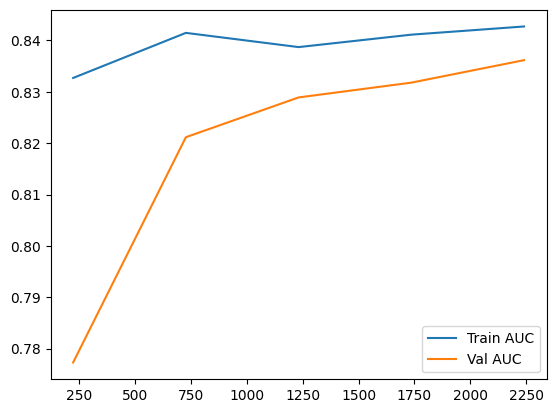

In [25]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model_logistic, X_train, y_train, 
    cv=5, scoring="roc_auc")

plt.plot(train_sizes, train_scores.mean(axis=1), label='Train AUC')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Val AUC')
plt.legend()
plt.show()

### c) Cross validation score

In [26]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    model_logistic, X_train, y_train,
    cv=5, scoring="roc_auc"
)


print(cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())


c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[0.83313715 0.84044324 0.82043268 0.84759062 0.83920372]
Mean: 0.8361614816549073
Std: 0.009107750011327994


c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### d) Log loss

In [27]:
from sklearn.metrics import log_loss

train_proba = model_logistic.predict_proba(X_train)
val_proba   = model_logistic.predict_proba(X_val)

train_logloss = log_loss(y_train, train_proba)
val_logloss   = log_loss(y_val, val_proba)

print("Train log loss:", train_logloss)
print("Validation log loss:", val_logloss)

Train log loss: 0.4842600517079733
Validation log loss: 0.5057102121503836


c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### e) Features importances computed

In [28]:
importance_logistic_regression = pd.Series(model_logistic.coef_[0], index=X.columns).sort_values(ascending=False)
importance_logistic_regression 

adjective ratio_prompt          0.391025
num_numbers_cot                 0.287907
stop ratio_cot                  0.257680
max_sentence_length_prompt      0.203548
verb ratio_cot                  0.182781
                                  ...   
noun ratio_cot                 -0.289613
overall sentiment_cot          -0.507501
cosine similarity prompt-CoT   -0.536658
Dale-Chall Score_cot           -0.612995
bleurt                         -1.802771
Length: 63, dtype: float64

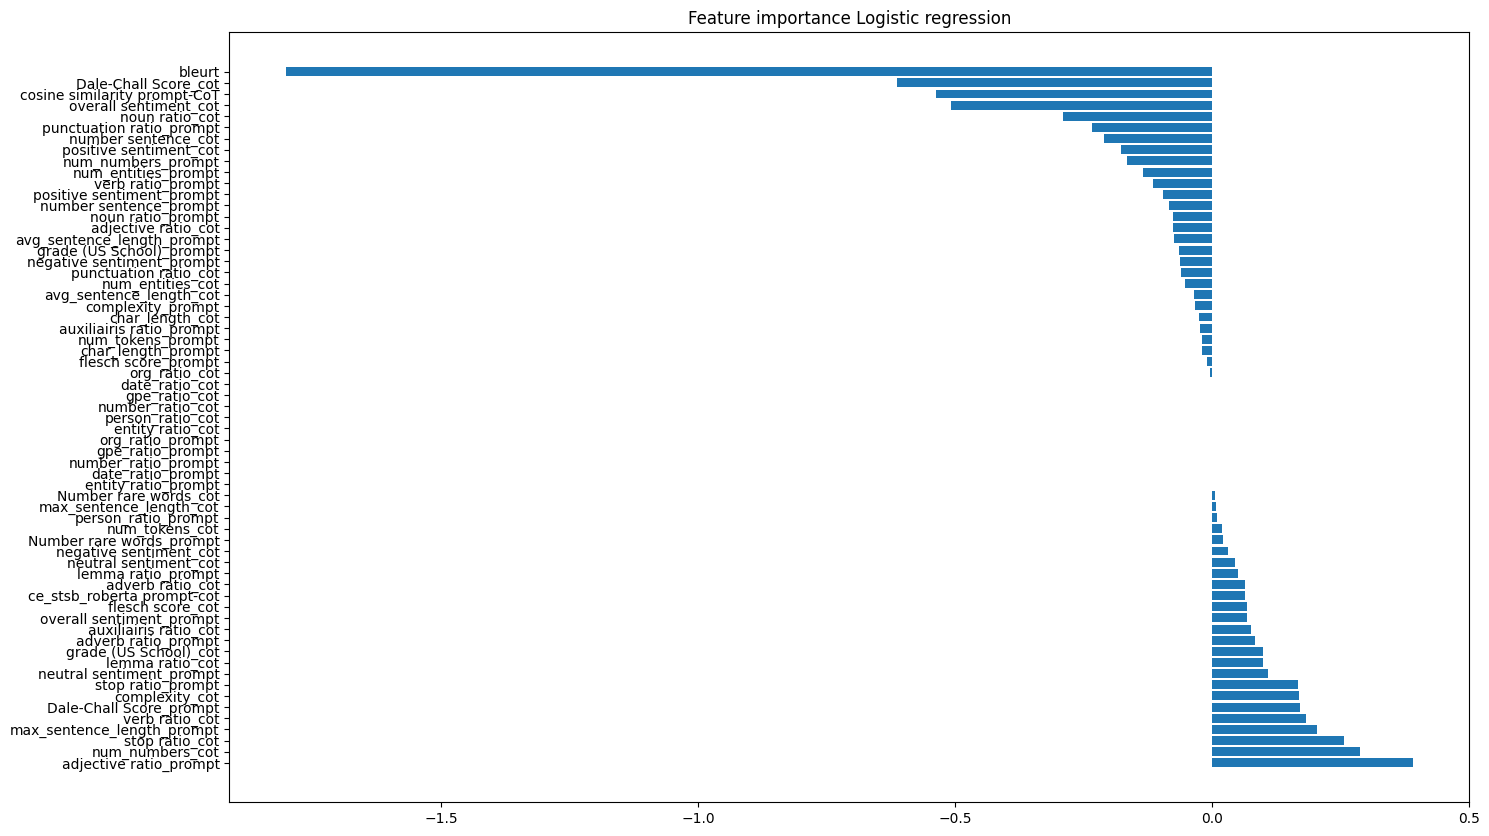

In [30]:
plt.figure(figsize=(16, 10))
plt.barh(importance_logistic_regression.index, importance_logistic_regression.values)
plt.title('Feature importance Logistic regression')
plt.show()

## II) Correlation matrix

In [35]:
corr_matrix = input_df.corr()  
corr_matrix = corr_matrix['hallucination score']
corr_matrix = corr_matrix.drop(['hallucination score'])
corr_matrix = corr_matrix.sort_values(ascending=False)
corr_matrix

flesch score_cot         0.417764
number_ratio_cot         0.364694
stop ratio_cot           0.333700
num_numbers_cot          0.330892
verb ratio_cot           0.296766
                           ...   
num_tokens_cot          -0.300875
Dale-Chall Score_cot    -0.346412
adjective ratio_cot     -0.368402
noun ratio_cot          -0.392158
Number rare words_cot   -0.431970
Name: hallucination score, Length: 63, dtype: float64

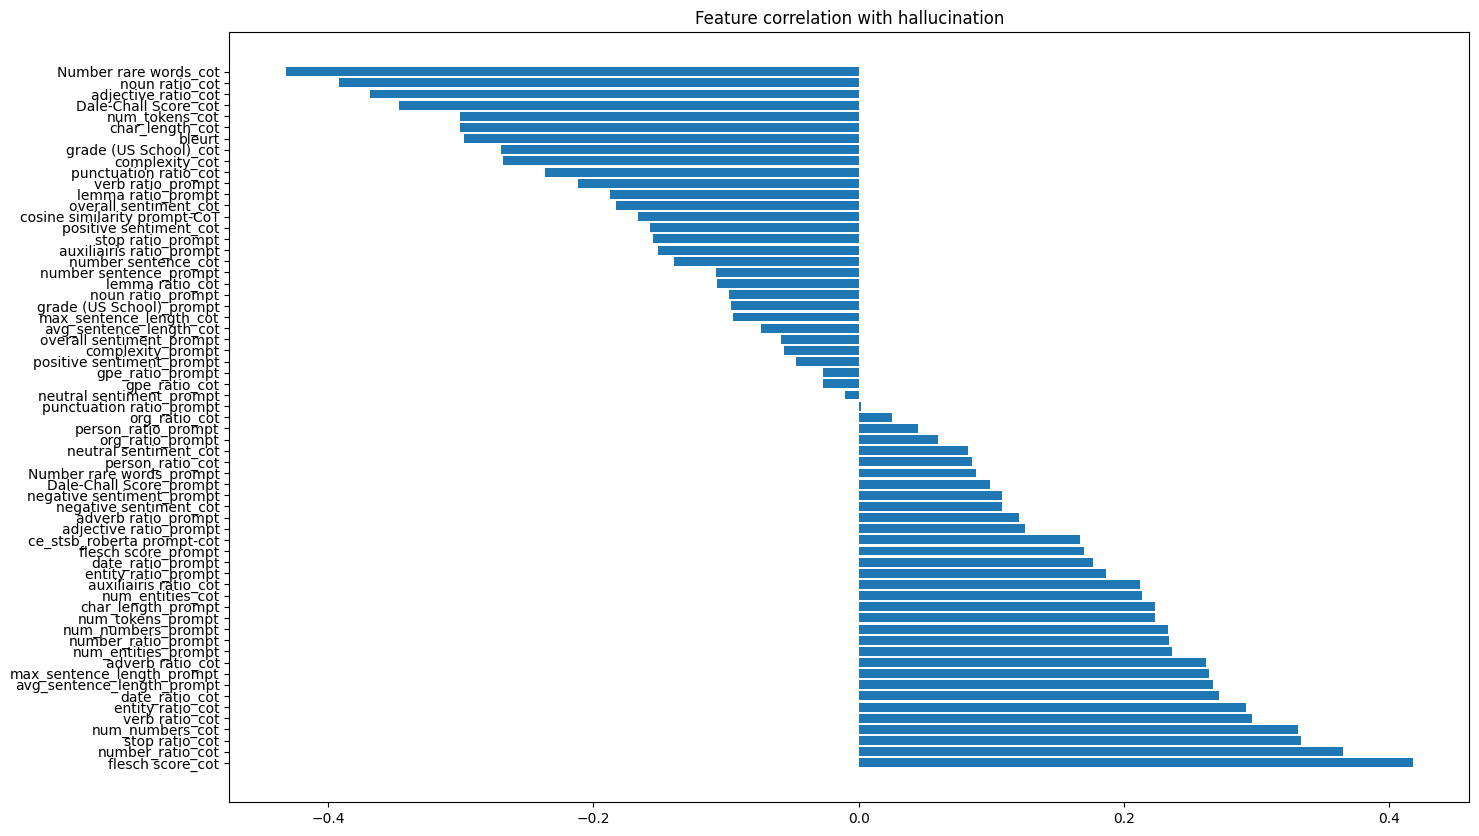

In [36]:
plt.figure(figsize=(16, 10))
plt.barh(corr_matrix.index, corr_matrix.values)
plt.title('Feature correlation with hallucination')
plt.show()

## III) Mutual Information

In [37]:
mi = mutual_info_classif(X, y)
mi_df = pd.Series(mi, index=X.columns).sort_values(ascending=False)
mi_df

number_ratio_cot             0.124587
Number rare words_cot        0.115099
flesch score_cot             0.111013
noun ratio_cot               0.107954
stop ratio_cot               0.107802
                               ...   
max_sentence_length_cot      0.010326
gpe_ratio_prompt             0.008755
negative sentiment_prompt    0.005529
adverb ratio_prompt          0.002412
number sentence_prompt       0.000783
Length: 63, dtype: float64

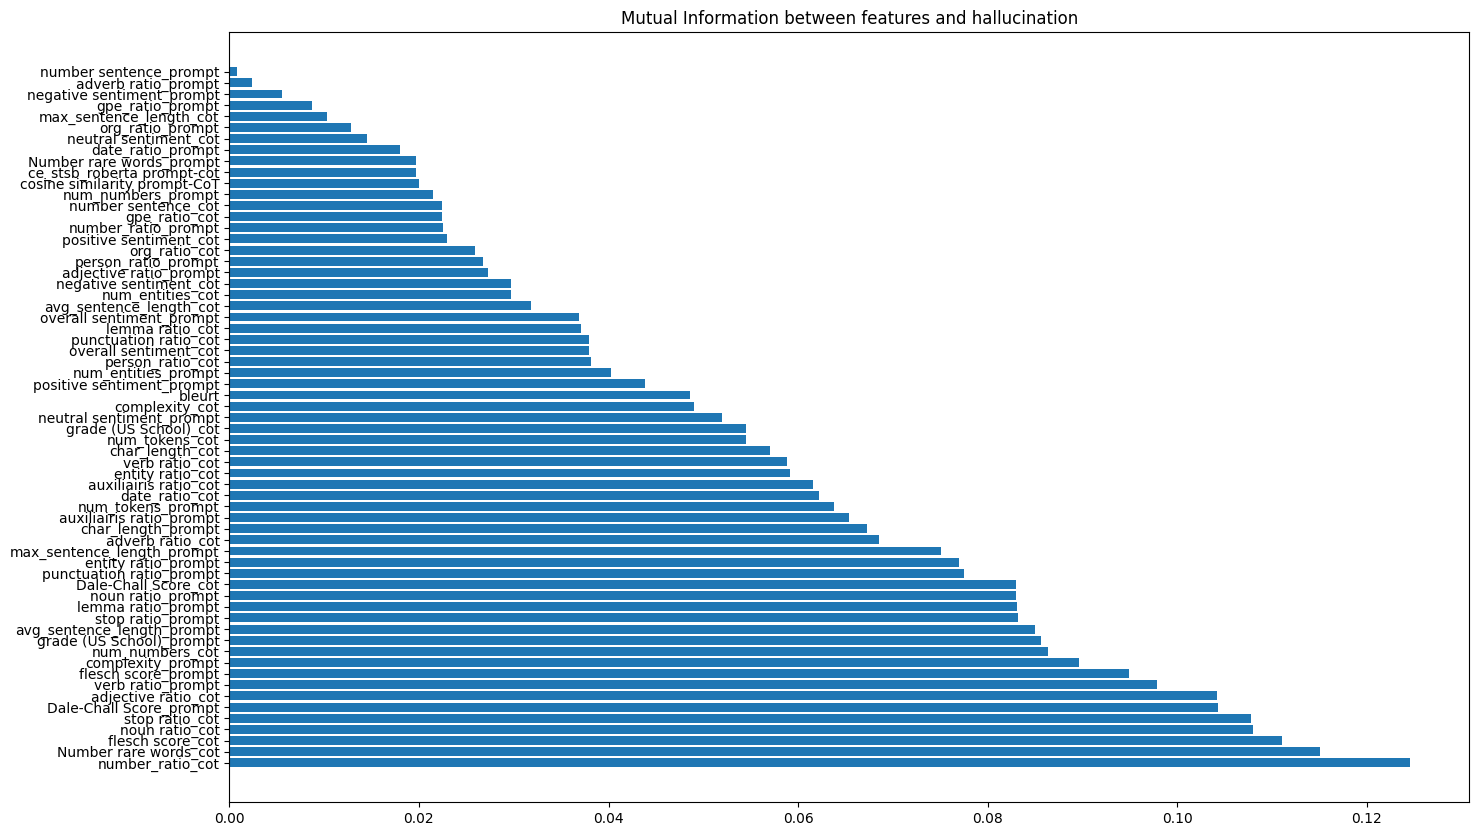

In [38]:
plt.figure(figsize=(16, 10))
plt.barh(mi_df.index, mi_df.values)
plt.title('Mutual Information between features and hallucination')
plt.show()

## IV) Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=8,            
    min_samples_split=40,    
    min_samples_leaf=20,     
    max_features=0.3,        
    class_weight='balanced',
    random_state=524,
)
rf.fit(X_train, y_train)


,n_estimators,400
,criterion,'gini'
,max_depth,8
,min_samples_split,40
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,0.3
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### a) Log loss

In [40]:
from sklearn.metrics import log_loss

train_loss = log_loss(y_train, rf.predict_proba(X_train))
val_loss   = log_loss(y_val,   rf.predict_proba(X_val))

print("Train log-loss:", train_loss)
print("Val log-loss  :", val_loss)

Train log-loss: 0.35417861231804715
Val log-loss  : 0.41818835215276223


### b) Cross validation

In [41]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    rf, X, y, cv=5, scoring='accuracy'
)

print(cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())


[0.385  0.8525 0.95   0.955  0.7925]
Mean: 0.787
Std: 0.21010354590058683


### c) Learning curves

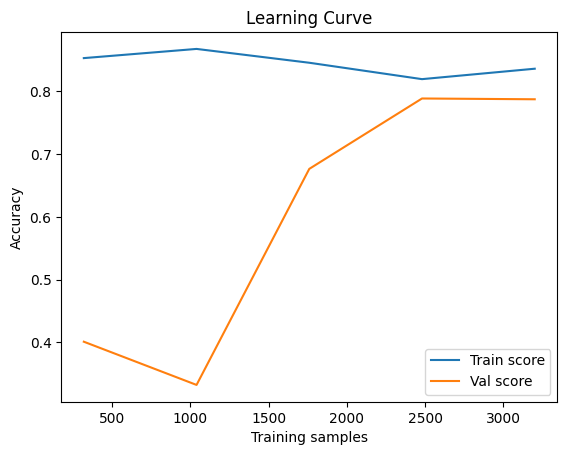

In [42]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    rf,
    X,
    y,
    cv=5,
    scoring="accuracy",
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train score")
plt.plot(train_sizes, val_mean, label="Val score")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

### d) ROC-AUX score

In [43]:
train_proba = rf.predict_proba(X_train)[:, 1]
val_proba = rf.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_proba))
print("Val ROC-AUC:", roc_auc_score(y_val, val_proba))

Train ROC-AUC: 0.9471659624543902
Val ROC-AUC: 0.871832295577867


In [44]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

rf.fit(X_train_full, y_train_full)

y_test_pred = model_logistic.predict(X_test)
y_test_proba = model_logistic.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

Test ROC-AUC: 0.8350547066591208
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       372
           1       0.66      0.63      0.64       228

    accuracy                           0.74       600
   macro avg       0.72      0.72      0.72       600
weighted avg       0.73      0.74      0.74       600



c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### e) Features importances

In [45]:
feature_importance_rf = rf.feature_importances_

feature_names = X_train.columns


rf_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importance_rf
}).sort_values(by="importance", ascending=False)

rf_importance_df

,feature,importance
41,number_ratio_cot,0.167322
50,Number rare words_cot,0.145936
23,noun ratio_cot,0.085112
47,flesch score_cot,0.069592
25,adjective ratio_cot,0.068485
...,...,...
52,negative sentiment_prompt,0.000389
19,num_numbers_prompt,0.000298
0,number sentence_prompt,0.000221
17,gpe_ratio_prompt,0.000178


C:\Users\turki\AppData\Local\Temp\ipykernel_26068\459821039.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


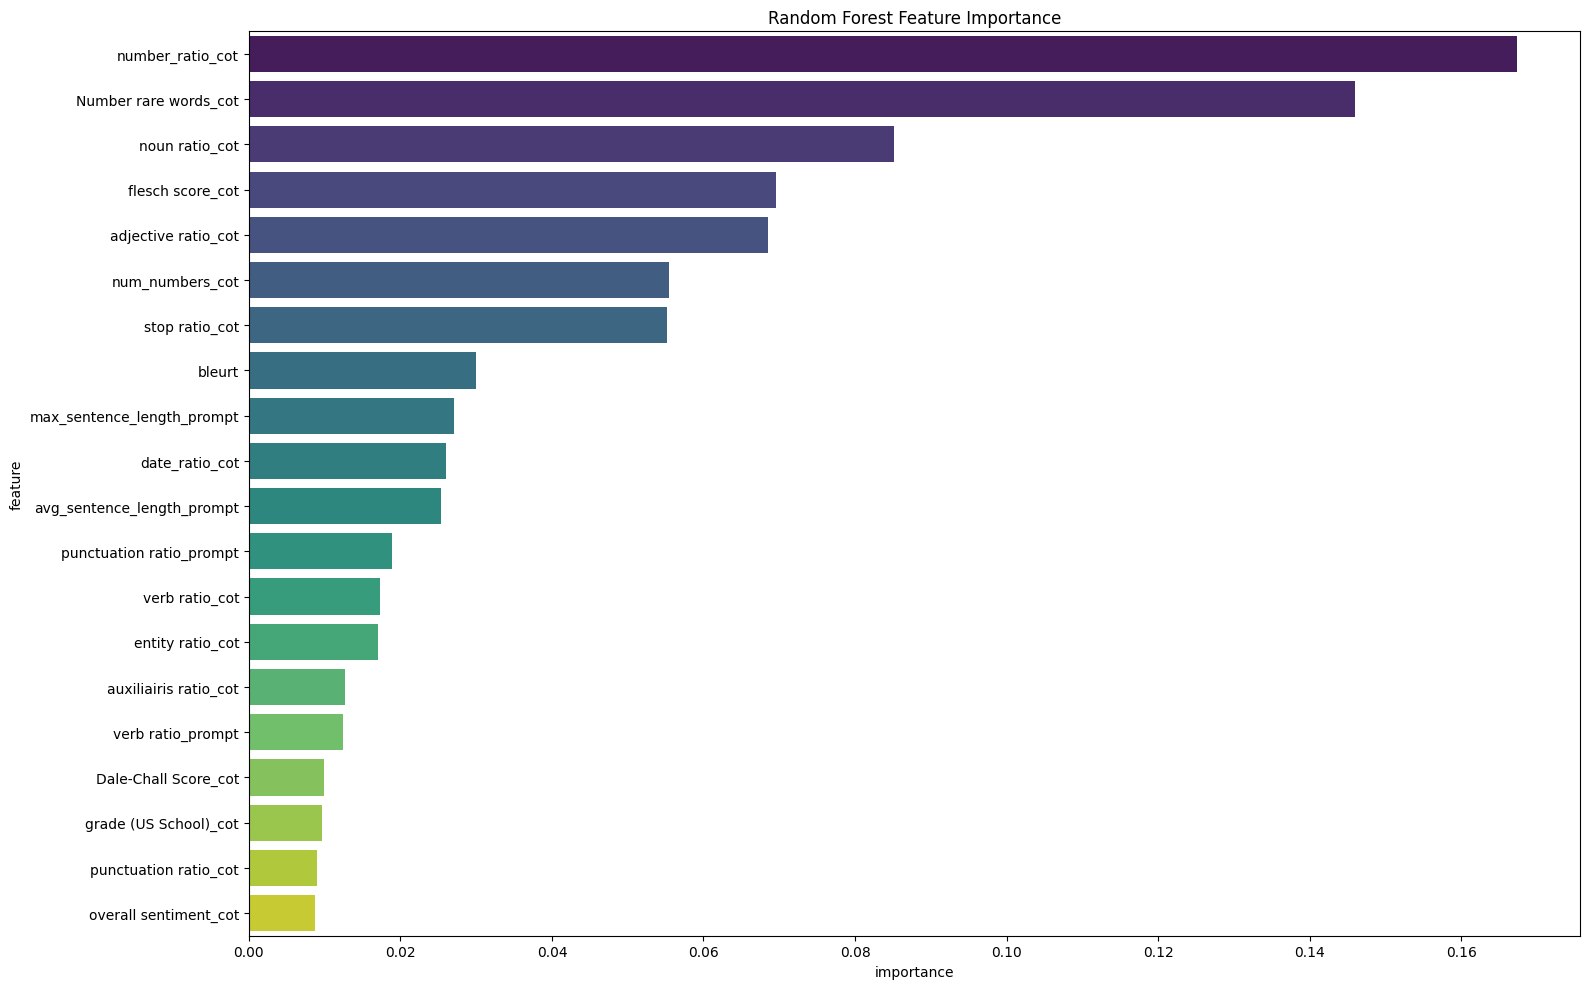

In [46]:
top_k = 20

plt.figure(figsize=(16, 10))

sns.barplot(
    data=rf_importance_df.head(top_k),
    x="importance",
    y="feature",
    palette="viridis"
)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

## V) Xgboost

In [47]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=2000,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    reg_lambda=1,
    reg_alpha=1,
    
    objective="binary:logistic",
    random_state=524,
)

xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)



[0]	validation_0-logloss:0.66112
[1]	validation_0-logloss:0.65726
[2]	validation_0-logloss:0.65371
[3]	validation_0-logloss:0.65047
[4]	validation_0-logloss:0.64734
[5]	validation_0-logloss:0.64384
[6]	validation_0-logloss:0.64046
[7]	validation_0-logloss:0.63729
[8]	validation_0-logloss:0.63406
[9]	validation_0-logloss:0.63093
[10]	validation_0-logloss:0.62754
[11]	validation_0-logloss:0.62478
[12]	validation_0-logloss:0.62209
[13]	validation_0-logloss:0.61904
[14]	validation_0-logloss:0.61598
[15]	validation_0-logloss:0.61352
[16]	validation_0-logloss:0.61059
[17]	validation_0-logloss:0.60807
[18]	validation_0-logloss:0.60531
[19]	validation_0-logloss:0.60265
[20]	validation_0-logloss:0.60000
[21]	validation_0-logloss:0.59744
[22]	validation_0-logloss:0.59462
[23]	validation_0-logloss:0.59200
[24]	validation_0-logloss:0.58923
[25]	validation_0-logloss:0.58692
[26]	validation_0-logloss:0.58444
[27]	validation_0-logloss:0.58202
[28]	validation_0-logloss:0.57938
[29]	validation_0-loglos

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### a) Log loss

In [48]:
train_pred_proba = xgb.predict_proba(X_train)
val_pred_proba   = xgb.predict_proba(X_val)

print("Train log-loss:", log_loss(y_train, train_pred_proba))
print("Val log-loss  :", log_loss(y_val,   val_pred_proba))


Train log-loss: 0.0704897783485182
Val log-loss  : 0.3806770238530641


### b) Cross validation

In [49]:
from sklearn.model_selection import  StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=564)

cv_scores = cross_val_score(
    xgb,
    X, y,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

print("CV Scores:", cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())

CV Scores: [0.82625 0.81625 0.81625 0.80625 0.7825 ]
Mean: 0.8095000000000001
Std: 0.014908051515875598


### c) Learning curves

c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\xgboost\sklearn.py", line 1758, in fit
    raise ValueE

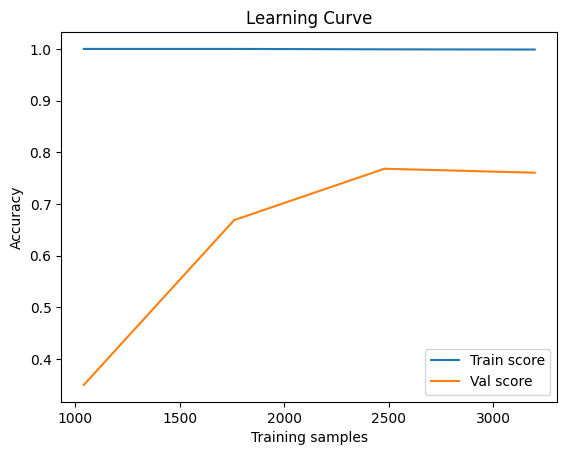

In [50]:
train_sizes, train_scores, val_scores = learning_curve(
    xgb,
    X,
    y,
    cv=5,
    scoring="accuracy",
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train score")
plt.plot(train_sizes, val_mean, label="Val score")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

### d) ROC-AUX curve

In [51]:
train_proba = xgb.predict_proba(X_train)[:, 1]
val_proba = xgb.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_proba))
print("Val ROC-AUC:", roc_auc_score(y_val, val_proba))

Train ROC-AUC: 0.9999853983887392
Val ROC-AUC: 0.8895820336868371


In [52]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

rf.fit(X_train_full, y_train_full)

y_test_pred = xgb.predict(X_test)
y_test_proba = xgb.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

Test ROC-AUC: 0.8903272967364647
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       372
           1       0.71      0.80      0.75       228

    accuracy                           0.80       600
   macro avg       0.79      0.80      0.79       600
weighted avg       0.81      0.80      0.80       600



### e) Features importances

In [53]:
booster = xgb.get_booster()
importance_dict = booster.get_score(importance_type='gain')

xgb_imp = pd.Series(importance_dict)

xgb_imp = xgb_imp.sort_values(ascending=False)
print(xgb_imp)

number_ratio_cot              13.511721
Number rare words_cot         13.081992
max_sentence_length_prompt     7.703330
avg_sentence_length_prompt     5.815821
num_numbers_cot                5.635831
                                ...    
flesch score_prompt            1.376174
max_sentence_length_cot        1.343822
grade (US School)_prompt       1.309736
avg_sentence_length_cot        1.301618
org_ratio_prompt               1.194164
Length: 63, dtype: float64


  0%|          | 0/1000 [00:00<?, ?it/s]

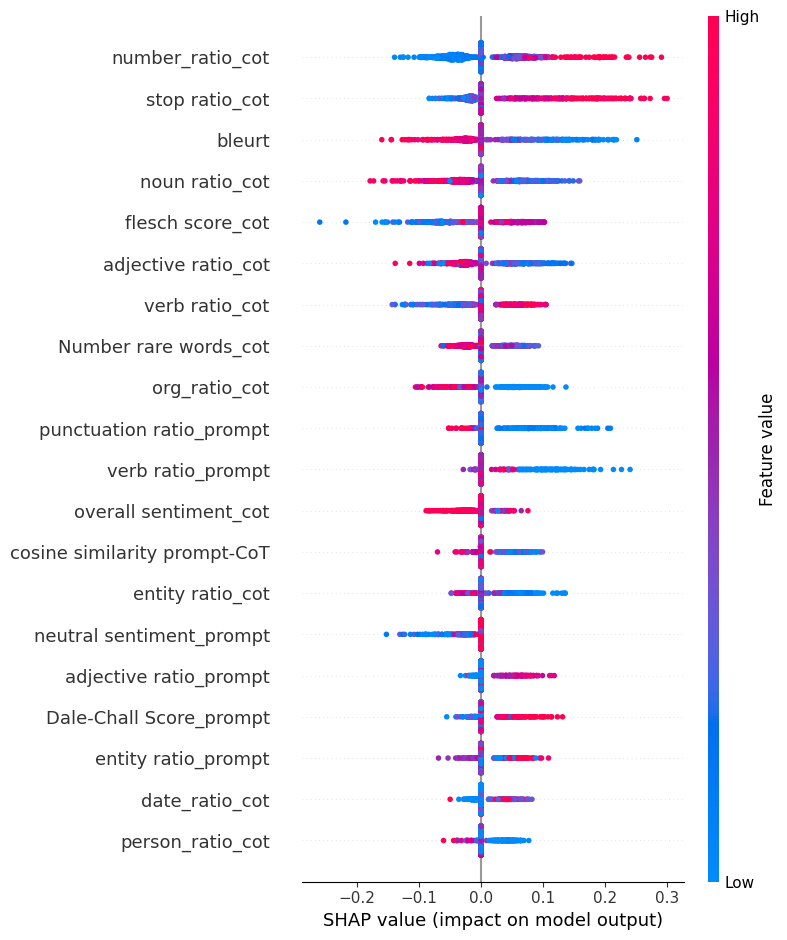

In [54]:
import shap

def xgb_predict(X):
    return xgb.predict_proba(X)[:, 1]


background = shap.kmeans(X_train, 30)
X_explain = X_train.sample(1000, random_state=524)

explainer = shap.KernelExplainer(xgb_predict, background)

shap_values = explainer.shap_values(X_explain, nsamples=500)

shap.summary_plot(shap_values, X_explain, feature_names=X_train.columns)

## VI) SVM with RBF Kernel

In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

svm = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
)

svm.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


### a) Log loss

In [56]:
train_pred_proba = svm.predict_proba(X_train)
val_pred_proba   = svm.predict_proba(X_val)

print("Train log-loss:", log_loss(y_train, train_pred_proba))
print("Val log-loss  :", log_loss(y_val,   val_pred_proba))


Train log-loss: 0.23906420368775186
Val log-loss  : 0.3874050614400357


### b) Cross validation score

In [57]:
cv_scores = cross_val_score(
    svm, X, y, cv=5, scoring='accuracy'
)

print(cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())


[0.38125 0.84375 0.93    0.90875 0.8225 ]
Mean: 0.7772500000000001
Std: 0.20194584670153531


### c) Learning curves

c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklear

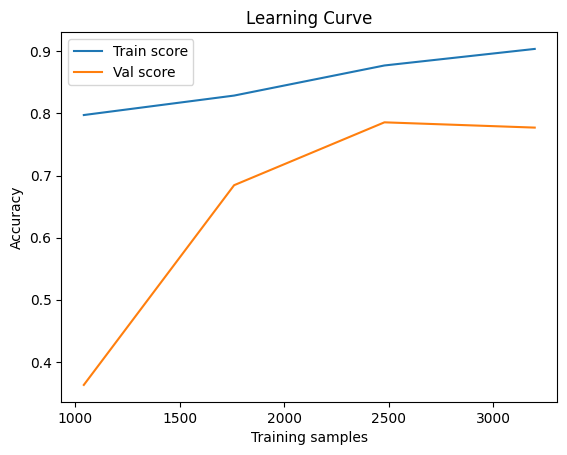

In [58]:
train_sizes, train_scores, val_scores = learning_curve(
    svm,
    X,
    y,
    cv=5,
    scoring="accuracy",
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train score")
plt.plot(train_sizes, val_mean, label="Val score")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

### d) ROC-AUX score

In [59]:
train_proba = svm.predict_proba(X_train)[:, 1]
val_proba = svm.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_proba))
print("Val ROC-AUC:", roc_auc_score(y_val, val_proba))

Train ROC-AUC: 0.974929844665896
Val ROC-AUC: 0.8810249649831096


In [60]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

svm.fit(X_train_full, y_train_full)

y_test_pred = svm.predict(X_test)
y_test_proba = svm.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

Test ROC-AUC: 0.8911997736276174
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       372
           1       0.71      0.89      0.79       228

    accuracy                           0.82       600
   macro avg       0.82      0.83      0.82       600
weighted avg       0.84      0.82      0.82       600



c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\turki\miniconda3\envs\env_hallu\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


### e) Features importance

In [ ]:
def svm_predict(X):
    return svm.predict_proba(X)[:, 1]

background = shap.kmeans(X_train, 30)
X_explain = X_train.sample(300, random_state=524)

explainer = shap.KernelExplainer(svm_predict, background)
shap_values = explainer.shap_values(X_explain, nsamples=100)
shap.summary_plot(shap_values, X_explain, feature_names=X_train.columns)


  0%|          | 0/300 [00:00<?, ?it/s]

## VII) Multilayer Perceptron Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    learning_rate_init=0.001,
    alpha=1e-3,          
    max_iter=2000,
    early_stopping=True
)


mlp.fit(X_train, y_train)

### a) Log loss

In [ ]:
train_pred_proba = mlp.predict_proba(X_train)
val_pred_proba   = mlp.predict_proba(X_val)

print("Train log-loss:", log_loss(y_train, train_pred_proba))
print("Val log-loss  :", log_loss(y_val,   val_pred_proba))

### b) Cross validation

In [ ]:
cv_scores = cross_val_score(
    mlp, X, y, cv=5, scoring='accuracy'
)

print(cv_scores)
print("Mean:", cv_scores.mean())
print("Std:", cv_scores.std())


### c) Learning curves

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    mlp,
    X,
    y,
    cv=5,
    scoring="accuracy",
)

train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Train score")
plt.plot(train_sizes, val_mean, label="Val score")
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.legend()
plt.show()

### d) ROC-AUX scores

In [ ]:
train_proba = mlp.predict_proba(X_train)[:, 1]
val_proba = mlp.predict_proba(X_val)[:, 1]

print("Train ROC-AUC:", roc_auc_score(y_train, train_proba))
print("Val ROC-AUC:", roc_auc_score(y_val, val_proba))

In [ ]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.concatenate([y_train, y_val])

mlp.fit(X_train_full, y_train_full)

y_test_pred = mlp.predict(X_test)
y_test_proba = mlp.predict_proba(X_test)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print(classification_report(y_test, y_test_pred))

### e) Features importances

In [ ]:
import shap

def mlp_predict(X):
    return mlp.predict_proba(X)[:, 1]

background = shap.kmeans(X_train, 30)
X_explain = X_train.sample(2000, random_state=524)

explainer = shap.KernelExplainer(mlp_predict, background)
shap_values = explainer.shap_values(X_explain, nsamples=500)
shap.summary_plot(shap_values, X_explain, feature_names=X_train.columns)
